<title>HTML Elements Reference</title>

<center style='font-size:28px;'><u><b>Game Sales Analysis</b></u></center>

# Description

Ice online store sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. This analysis aims to identify patterns that determine whether a game succeeds or not. This will allow to spot potential big winners and plan advertising campaigns.

- Central purpose of this analysis is to forecast 2017 most profitable games.
- Data for 2016 may be incomplete

# Importing

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

# Reading file

In [2]:
try:
    games = pd.read_csv('games.csv')
except:
    games = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Some columns contain missing values

In [4]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


# Pre-processing

In [5]:
games.columns = games.columns.str.lower() #easier like this

In [6]:
games.name = games.name.astype('string')

In [7]:
games.platform = games.platform.astype('string')

In [8]:
games.genre = games.genre.astype('string')

`Year_of_Release` is always an integer, so it should have an int type. Because its float at present, and containing Nan's, it must be filled before casting:

In [9]:
games.year_of_release = games.year_of_release.fillna(0).astype('int64')
games.rename(columns={'year_of_release': 'year'}, inplace=True) # easier to deal with

- 'Nan' VALUES ARE NOW SET TO 0

In [10]:
tmp = np.floor(games.critic_score)
games['critic_score'] -= tmp
games.critic_score.value_counts()

0.0    8137
Name: critic_score, dtype: int64

Its all integers. As before, its a floats column containing Nan's, so filling is needed before casting. 0 is a possible score, so to not confuse between the two, Nan's will be filled with -1.

In [11]:
games.critic_score += tmp # before that line the column was zeroed because of the latter cell
games.critic_score = games.critic_score.fillna(-1).astype('int64')

- 'Nan' VALUES ARE NOW SET TO -1

### `user_score`

In [12]:
games.user_score.value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.3       2
1.3       2
1.1       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

There are a lot of 'tbd' values - about 25% of all user scores that are not Nan's.
For easier analysis, its better `user_score` will consist of floats. So, tbd's will be replaced by -1. `user_score` varies between 0 to 10 so it should not interfere.

In [13]:
len(games[games['user_score'] == -1]) # making sure -1 is "clear"

0

Free for use

In [14]:
games.loc[games['user_score'] == 'tbd','user_score'] = -1 # changing tbd's to -1
games.user_score = games.user_score.astype('float64') # it represents a float anyway

- NOW 'TBD' VALUES ARE SET TO -1. NAN's STILL PRESENT

### `rating`

In [15]:
games.rating.value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

In [16]:
games.rating = games.rating.astype('str') #its strings anyway

In [17]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16713 non-null  string 
 1   platform      16715 non-null  string 
 2   year          16715 non-null  int64  
 3   genre         16713 non-null  string 
 4   na_sales      16715 non-null  float64
 5   eu_sales      16715 non-null  float64
 6   jp_sales      16715 non-null  float64
 7   other_sales   16715 non-null  float64
 8   critic_score  16715 non-null  int64  
 9   user_score    10014 non-null  float64
 10  rating        16715 non-null  object 
dtypes: float64(5), int64(2), object(1), string(3)
memory usage: 1.4+ MB


<div style="font-size:20px;">Now all data types are properly set. <b style="color:red;">However, the presence of 0 in year_of_release and -1 in critic_score instead of Nan's, and the presence of -1 in user_score instead of tbd's should not be forgotten</b></div>

## Duplicates

In [18]:
games.duplicated().sum()

0

<div style="font-size:20px;">Its all good</div>

## Dealing with missing values

In [19]:
games.isnull().sum()/len(games)

mis_values = games.isnull().sum().to_frame('missing_values')
mis_values['%'] = round(games.isnull().sum()/len(games),3)
mis_values.sort_values(by='%', ascending=False)

,missing_values,%
user_score,6701,0.401
name,2,0.000
platform,0,0.000
year,0,0.000
genre,2,0.000
na_sales,0,0.000
eu_sales,0,0.000
jp_sales,0,0.000
other_sales,0,0.000
critic_score,0,0.000


### 'name' and 'genre' missing values

In [20]:
games[games['name'].isna()]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,<NA>,GEN,1993,<NA>,1.78,0.53,0.00,0.08,-1,NaN,nan
14244,<NA>,GEN,1993,<NA>,0.00,0.00,0.03,0.00,-1,NaN,nan


In [21]:
games[games['genre'].isna()]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,<NA>,GEN,1993,<NA>,1.78,0.53,0.00,0.08,-1,NaN,nan
14244,<NA>,GEN,1993,<NA>,0.00,0.00,0.03,0.00,-1,NaN,nan


<div style="font-size:20px;">So 'name' and 'genre' missing values are on the same rows. For both, sales are very low, ratings and scores are missing, and platform and year are the same: GEN and 1993. A sub purpose of this analysis is to find a relation between year and platform, to sales. Those problematic rows are important - they're both the same (for year, platform and sales) so their importance is doubled</div>

In [22]:
tmp1993 = games.year.value_counts()[1993]
print(f'Total games in 1993 - {tmp1993}')

tmpna = len(games[games['year'] == 0])
tmptotal =len(games.year)
print(f'Proportion of games from 1993 - {tmp1993 / (tmptotal - tmpna)}')

Total games in 1993 - 62
Proportion of games from 1993 - 0.003769913656816247


<div style="font-size:20px;">That's not a big portion for 1993 in total games - 0.3%. So, disregarding 2 rows will make a relatively big impact on the analysis results (who concern 1993) - There are'nt many games released in 1993, so each one of them has a bigger significance</div>

In [23]:
tmpGEN = games.platform.value_counts()['GEN']
print(f'Total games for GEN - {tmpGEN}')

tmpna = games.platform.isna().sum()
tmptotal =len(games.platform)
print(f'Proportion of games for GEN platform - {tmpGEN / (tmptotal - tmpna)}')

Total games for GEN - 29
Proportion of games for GEN platform - 0.001734968591085851


<div style="font-size:20px;">Again, that's not a lot of games for the GEN platform, so disregarding 2 rows will make a relatively big impact on the relevant analysis results.</div>

<div style="font-size:20px;"><b>So, its better <b style="color:red;">not</b> to fill 'name' and 'genre' columns.</b></div> 

### 'year' missing values

In [24]:
games.year.value_counts().sort_index()

0        269
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      62
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: year, dtype: int64

<div style="font-size:20px;">It appears the earliest release was at 1980, and that there are 269 missing year values</div>

In [25]:
missed_years = games[games['year'] == 0]
missed_years

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,0,Sports,4.26,0.26,0.01,0.71,94,8.5,E
377,FIFA Soccer 2004,PS2,0,Sports,0.59,2.36,0.04,0.51,84,6.4,E
456,LEGO Batman: The Videogame,Wii,0,Action,1.80,0.97,0.00,0.29,74,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,0,Fighting,1.57,1.02,0.00,0.41,-1,NaN,nan
609,Space Invaders,2600,0,Shooter,2.36,0.14,0.00,0.03,-1,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,0,Sports,0.01,0.00,0.00,0.00,43,-1.0,E10+
16405,Freaky Flyers,GC,0,Racing,0.01,0.00,0.00,0.00,69,6.5,T
16448,Inversion,PC,0,Shooter,0.01,0.00,0.00,0.00,59,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,0,Adventure,0.01,0.00,0.00,0.00,-1,NaN,nan


<div style="font-size:20px;">One of the goals of this analysis is to look at the total amount of games released per year. Its important the filled missing-years values will be filled <b>reliably</b> - Only if there's a strong chance the value filled is indeed the value in reality. Its possible that for some years, the total amount of games released will change considerably after filling reliably the missing values. Its important to fill them, while also important to do it carefully.</div>

<div style="font-size:20px;">The factors influencing the values for filling missing years reliably are name and platform. Although its possible there's a connection between genre,sales,scores and rating to 'year', the constraint of filling reliably makes it possible to fill missing values only if it makes common sense as well. Genre,sales,scores and rating are good for verifying the filling performed is proper, but even in the most extreme case, where in a big portion of rows a 1 to one 1 match will be found between some specific 4 values to the year value, filling based on that will feel too weird at room temprature</div>

<div style="font-size:20px;">In cases where a year is part of the game's name, the missing year value could be filled with the year present in the name. Its possible the actual year of release is a year before or after, but this uncertainty is accepted, while also noted for the rest of this analysis.</div>

<div style="font-size:20px;">Platform might have a connection to the technology existed at time of release - if such a connection between year and platform will be found, it'll make common sense to fill missing years accordingly. if not, missing values would not be filled based on platform information</div>

#### Filling by name

In [26]:
# extracting number from each name. when there's no such number, 'na' is 'extracted'
# keeping only useful rows by droping all the 'na' who came from names lacking numbers
tmp = missed_years['name'].str.extract('(\d+)').dropna().reset_index(level=0)
tmp.columns = ['original_index','year']
tmp.info()
tmp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   original_index  66 non-null     int64 
 1   year            66 non-null     string
dtypes: int64(1), string(1)
memory usage: 1.2 KB


,original_index,year
0,183,2004
1,377,2004
2,475,2006
3,719,3
4,1301,99
...,...,...
61,15953,2008
62,16079,2007
63,16293,1
64,16329,4


<div style="font-size:20px;">Only numbers representing relevant years are of interest - numbers between 1980 to 2016.
To keep only rows with those relevant numbers, casting is first needed, followed by slicing the latter data frame above.</div>

In [27]:
tmp.year = tmp.year.astype('int64')
tmp.drop(tmp[tmp.year < 1980].index, inplace=True)
tmp

,original_index,year
0,183,2004
1,377,2004
2,475,2006
6,1650,2003
13,2572,2009
21,3486,2002
24,4775,2003
26,5156,2003
29,5336,2013
31,5655,2005


In [28]:
# now filling games - with the indexes stored in tmp 'original_index', and the values in tmp 'year' are filled
for m in range(len(tmp)):
    games.iloc[tmp.iloc[m,0],2] = tmp.iloc[m,1]
print(f'values filled - {len(tmp)}')
print(f'current number of missing values - {games.year.value_counts()[0]}')

values filled - 17
current number of missing values - 252


<div style="font-size:20px;">It make sense - earlier there were 269 missing values, 17 more than now</div>

In [29]:
missed_years = games[games['year'] == 0] # updating missed_years
len(missed_years)

252

#### Filling by platform

In [30]:
valued_years = games.merge(missed_years, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', 1)
len(valued_years) # 16715 - 252 = 16463

16463

In [31]:
grouped_valued_years = valued_years.groupby('platform')['year'].count() # total valued_years games per platform

grouped_valued_years = grouped_valued_years.to_frame().add_suffix('').reset_index()
grouped_valued_years.rename(columns={'year':'valued_years'},inplace=True)
grouped_valued_years

,platform,valued_years
0,2600,116
1,3DO,3
2,3DS,512
3,DC,52
4,DS,2122
5,GB,97
6,GBA,811
7,GC,543
8,GEN,29
9,GG,1


In [32]:
grouped_missed_years = missed_years.groupby('platform')['year'].count().to_frame().add_suffix('').reset_index()
grouped_missed_years.rename(columns={'year':'missed_years'},inplace=True)
grouped_missed_years

,platform,missed_years
0,2600,17
1,3DS,8
2,DS,29
3,GB,1
4,GBA,11
5,GC,13
6,N64,3
7,PC,16
8,PS,7
9,PS2,27


In [33]:
merged_years = grouped_valued_years.merge(grouped_missed_years,how='inner',on='platform')
va = merged_years.valued_years.sum()
mi = merged_years.missed_years.sum() # its not all type of platforms so about 1408 rows are left out of both sums
merged_years['valued_years'] = merged_years['valued_years'] / va * 100
merged_years['missed_years'] = merged_years['missed_years'] / mi * 100
merged_years

,platform,valued_years,missed_years
0,2600,0.770508,6.746032
1,3DS,3.400864,3.174603
2,DS,14.094985,11.507937
3,GB,0.644304,0.396825
4,GBA,5.386915,4.365079
5,GC,3.606775,5.158730
6,N64,2.098970,1.190476
7,PC,6.363334,6.349206
8,PS,7.904351,2.777778
9,PS2,14.174693,10.714286


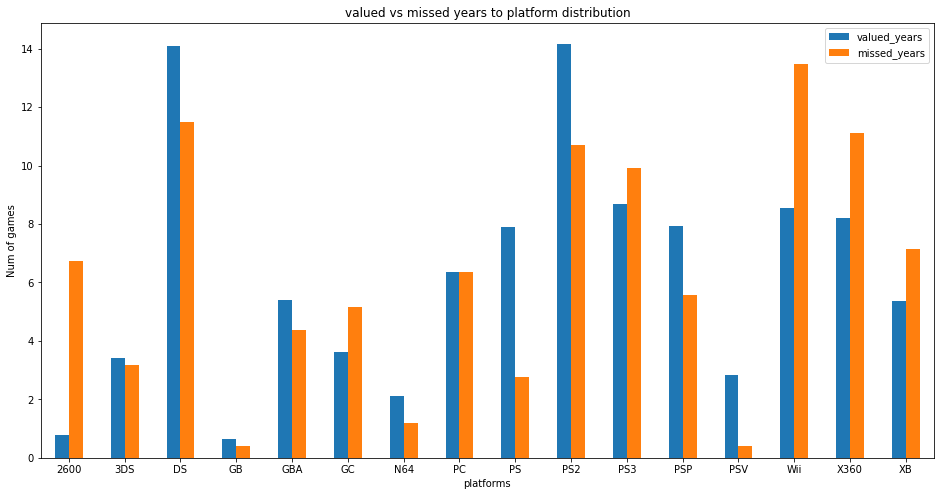

In [34]:
ax = merged_years.plot.bar(x='platform', y=['valued_years','missed_years'], rot=0, figsize=(16,8))
plt.title('valued vs missed years to platform distribution')
plt.xlabel('platforms')
plt.ylabel('Num of games')
plt.show()

<div style="font-size:20px;">There's generally a correlation between missed years platforms to valued years platforms. So, its a point in favor of filling missed years with relevant platform median. For platforms 2600, PS and PSV the correlation is pretty bad. The bad correlation for PSV is partly explained by the fact 2016 might have some missing data - as PSV games are at their peak around that year <b>(as seen later)</b>. Still, the correlation is overall pretty good.</div>

In [35]:
valued_years_stat = games[games['year'] != 0].groupby('platform')['year'].describe().sort_values(by='count',ascending=False)
valued_years_stat # statistics for valued years distribution over platforms

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
PS2,2134.0,2004.583411,2.564375,2000.0,2002.00,2005.0,2007.00,2011.0
DS,2122.0,2008.185203,1.778150,1985.0,2007.00,2008.0,2009.00,2013.0
PS3,1306.0,2010.840735,2.459616,2006.0,2009.00,2011.0,2013.00,2016.0
Wii,1286.0,2008.966563,1.542034,2006.0,2008.00,2009.0,2010.00,2016.0
X360,1234.0,2009.879254,2.457920,2005.0,2008.00,2010.0,2011.00,2016.0
PSP,1195.0,2008.731381,2.432123,2004.0,2006.50,2009.0,2011.00,2015.0
PS,1190.0,1998.005882,1.848091,1994.0,1997.00,1998.0,1999.00,2003.0
PC,958.0,2008.918580,4.642457,1985.0,2007.00,2010.0,2012.00,2016.0
GBA,811.0,2003.210851,1.474451,2000.0,2002.00,2003.0,2004.00,2007.0


In [36]:
valued_years_stat.loc['GG','std'] = 0 # std is 0 as there's only one sample for those platforms
valued_years_stat.loc['PCFX','std'] = 0

In [37]:
valued_years_stat[valued_years_stat['std'] > 2]

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
PS2,2134.0,2004.583411,2.564375,2000.0,2002.0,2005.0,2007.0,2011.0
PS3,1306.0,2010.840735,2.459616,2006.0,2009.0,2011.0,2013.0,2016.0
X360,1234.0,2009.879254,2.457920,2005.0,2008.0,2010.0,2011.0,2016.0
PSP,1195.0,2008.731381,2.432123,2004.0,2006.5,2009.0,2011.0,2015.0
PC,958.0,2008.918580,4.642457,1985.0,2007.0,2010.0,2012.0,2016.0
NES,98.0,1987.153061,2.793040,1983.0,1985.0,1986.5,1989.0,1994.0
GB,97.0,1995.958763,4.178111,1988.0,1992.0,1997.0,2000.0,2001.0


As witnessed by looking at differences between min to max, and between 25% to 75%, all 7 platforms are pretty concentrated, especially between Q1 to Q3. Thats enough to justify filling their respective missing year values with their median.

In [38]:
games['year'] = games['year'].replace(0,np.nan) # so fillna() will work.
games['year'] = games.groupby('platform')['year'].transform(lambda x: x.fillna(x.median()))

In [39]:
games[games['year'] != 0]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,-1,NaN,nan
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,-1,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,-1,NaN,nan
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,-1,NaN,nan
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,-1,NaN,nan
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,-1,NaN,nan


In [40]:
# 'year' column changed its type to float when 0 was replaced by nan
# bring it back to int
games['year'] = games['year'].astype('int64')

In [41]:
print(games['year'].isna().sum())

0


`year` column is entirely filled

### Rating missing values

In [42]:
games[games['rating'] == 'unknown'] # seems 'unknown' is clear
games.loc[games['rating'].isna(),'rating'] = 'unknown'
missed_ratings = games[games['rating'] == 'unknown']
games.rating.value_counts()

nan     6766
E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

<div style="font-size:20px;">A lot of unknowns. Genre is the only column with a logical common sense connection to rating - as it reflects the level of violence in the game. While rating likely has an effect on sales, and might have a connection to year and platform, none of them can be used to fill missing ratings, as it violates rules of common sense. Therefore, the task is to examine whether valued and unknown ratings distribute across genres the same. If they do, rating unknowns could be replaced by the most frequent rating for the relevant genre. If not, rating unknowns wont be replaced</div>

In [43]:
valued_ratings = games.merge(missed_ratings, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', 1)
valued_ratings
valued_ratings = valued_ratings.groupby('genre')['rating'].count().to_frame().add_suffix('').reset_index().rename(columns={'rating':'valued_rating'})
missed_ratings = missed_ratings.groupby('genre')['rating'].count().to_frame().add_suffix('').reset_index().rename(columns={'rating':'unknown_rating'})

In [44]:
merged_rating = valued_ratings.merge(missed_ratings,how='inner',on='genre')
va = merged_rating.valued_rating.sum()
mi = merged_rating.unknown_rating.sum() # its not all type of platforms so about 1408 rows are left out of both sums
merged_rating['valued_rating'] = merged_rating['valued_rating'] / va * 100
merged_rating['unknown_rating'] = merged_rating['unknown_rating'] / mi * 100
merged_rating

,genre,valued_rating,unknown_rating


<div style="font-size:20px;">The match is not that good. Ratings have a lot of missing values, about 40%, so a partially good match for 60% of the data is not good enough. So, unknown ratings will remain.</div>

### Critic_score missing values

In [45]:
games[games['user_score'].isna()]['critic_score'].value_counts()

-1     6663
 68       4
 88       3
 66       3
 87       2
 54       2
 83       2
 72       2
 57       2
 65       2
 62       2
 79       1
 63       1
 55       1
 86       1
 40       1
 46       1
 89       1
 44       1
 69       1
 61       1
 49       1
 33       1
 64       1
 85       1
Name: critic_score, dtype: int64

<div style="font-size:20px;">The absolute majority of user_score Nan's come with a corresponding 'critic_score' Nan (renamed -1). There are some 1500 more 'critic_score' Nan's, so if a method is found to fill 'critic_score', it would fill user_score as well.</div>

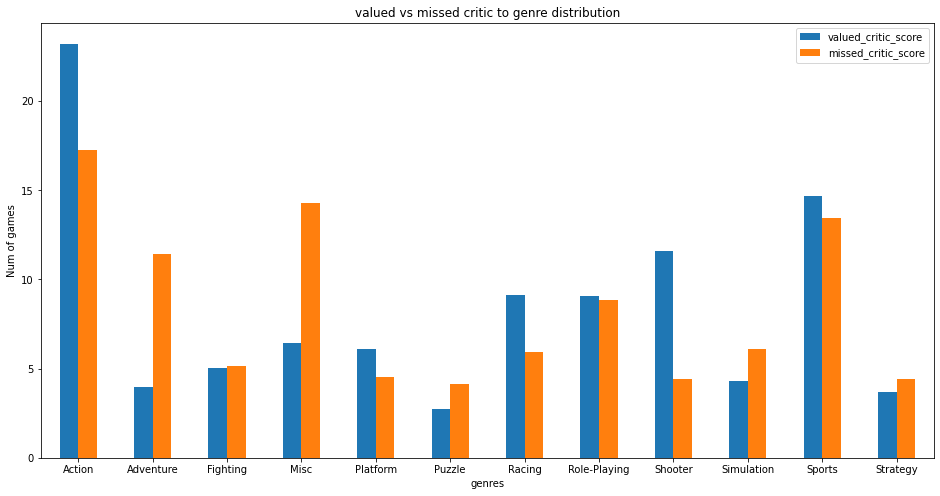

In [46]:
missed_critic_score = games[games['critic_score'] == -1]
missed_critic_score

valued_critic_score = games.merge(missed_critic_score, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', 1)
valued_critic_score
valued_critic_score = valued_critic_score.groupby('genre')['platform'].count().to_frame().add_suffix('').reset_index().rename(columns={'platform':'valued_critic_score'})
valued_critic_score
missed_critic_score = missed_critic_score.groupby('genre')['platform'].count().to_frame().add_suffix('').reset_index().rename(columns={'platform':'missed_critic_score'})
missed_critic_score

merged_critic = valued_critic_score.merge(missed_critic_score,how='inner',on='genre')

va = merged_critic.valued_critic_score.sum()
mi = merged_critic.missed_critic_score.sum() # its not all type of platforms so about 1408 rows are left out of both sums
merged_critic['valued_critic_score'] = merged_critic['valued_critic_score'] / va * 100
merged_critic['missed_critic_score'] = merged_critic['missed_critic_score'] / mi * 100
ax = merged_critic.plot.bar(x='genre', y=['valued_critic_score','missed_critic_score'], rot=0, figsize=(16,8))
plt.title('valued vs missed critic to genre distribution')
plt.xlabel('genres')
plt.ylabel('Num of games')
plt.show()

<div style="font-size:20px;">Again, not such a good match, for much less of the data, and for more missing values - 50% of critic_score is Nan, so it cannot be filled based on that. Critic_score will keep its missing values</div>

### User_score missing values

#### user_score tbd values

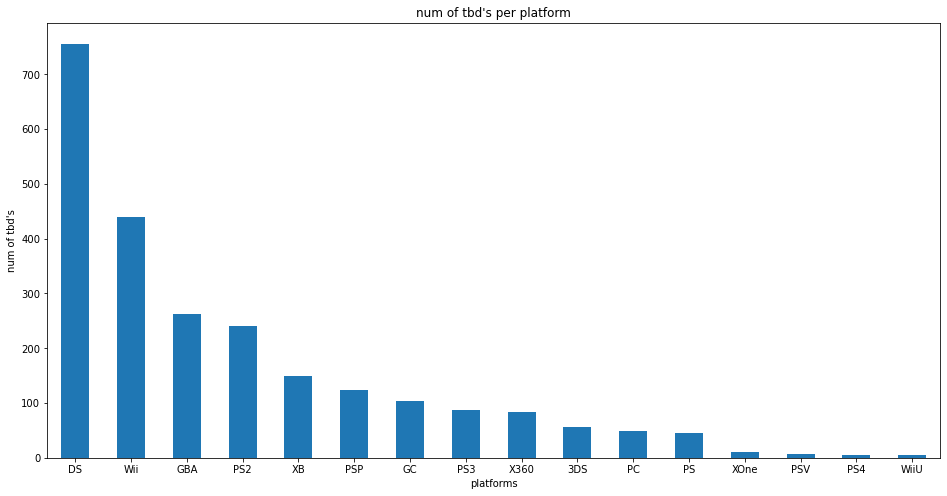

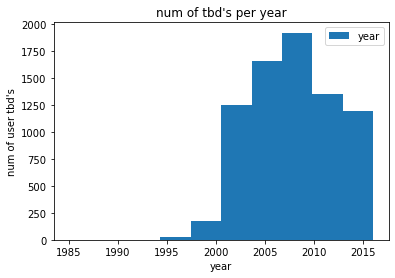

In [47]:
tbds = games[games['user_score'] == -1]['platform'].value_counts()
tbds.plot.bar(x='platform', y='user_score', rot=0, figsize=(16,8))
plt.xlabel('platforms')
plt.ylabel("num of tbd's")
plt.title("num of tbd's per platform")
plt.show()

# proper - not na, not 'tbd'
proper_user_score = games[games['user_score'] != -1].dropna(subset=['user_score'])
tbd_user_score = games[games['user_score'] == -1]

# len(games) - tbd's - (len(games) - non_null_user_score_from_the_info) =
# non_null_user_score_from_the_info - tbd's = 10014 - 2424 = 7590 = len(proper_user_score)

proper_user_score.plot(x='user_score', y='year',kind='hist', bins=10)
plt.xlabel('year')
plt.ylabel("num of user tbd's")
plt.title("num of tbd's per year")
plt.show()

<div style="font-size:20px;">The majority of tbd's is in rows having 4 platform values - DS, Wii, GBA and PS2. Those platforms were on the market at 2000 - 2011 (see below - 3 of the platforms are there as they're relevant to predict sales for 2017. GBA is not relevant for 2017, but checked as well, after all relevant to 2017 platforms, and found to have been in the market at the years mentioned - 2000 - 2011).</div>

In [48]:
games.groupby('year')['user_score'].median().sort_index()

year
1980     NaN
1981     NaN
1982     NaN
1983     NaN
1984     NaN
1985    5.80
1986     NaN
1987     NaN
1988    2.20
1989     NaN
1990     NaN
1991     NaN
1992    8.20
1993     NaN
1994    6.30
1995     NaN
1996    8.65
1997    8.30
1998    8.60
1999    8.50
2000    7.30
2001    7.50
2002    7.20
2003    8.00
2004    7.80
2005    7.60
2006    7.20
2007    6.70
2008    6.30
2009    5.70
2010    5.50
2011    6.00
2012    6.90
2013    6.60
2014    6.80
2015    6.80
2016    6.80
Name: user_score, dtype: float64

<div style="font-size:20px;">As witnessed in the cell above, in 2000 - 2011, the median user_score varied between 5.5 to 8. In general, user scores varies between 5 to 8, so that doesn't help fill user_score missing values.</div>

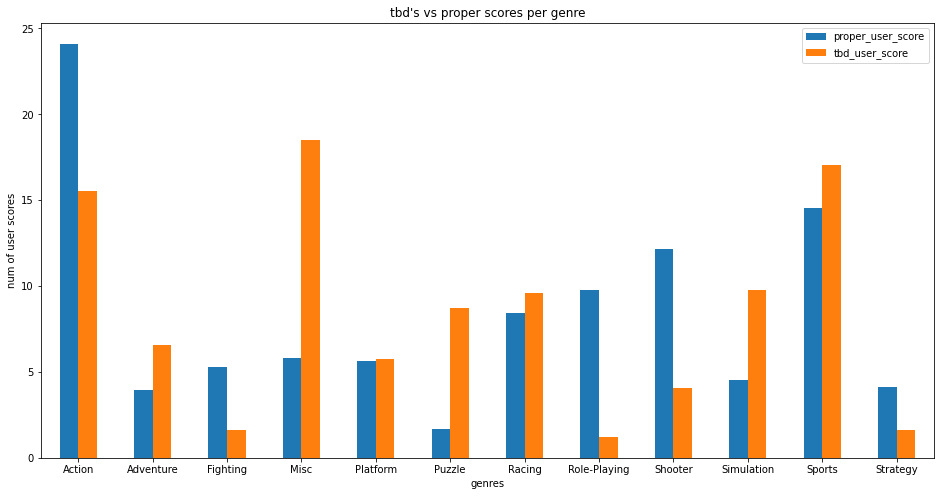

In [49]:
proper_user_score = proper_user_score.groupby('genre')['platform'].count().to_frame().add_suffix('').reset_index().rename(columns={'platform':'proper_user_score'})
tbd_user_score = tbd_user_score.groupby('genre')['platform'].count().to_frame().add_suffix('').reset_index().rename(columns={'platform':'tbd_user_score'})

merged_score = proper_user_score.merge(tbd_user_score,how='inner',on='genre')

va = merged_score.proper_user_score.sum()
mi = merged_score.tbd_user_score.sum() # its not all type of platforms so about 1408 rows are left out of both sums
merged_score['proper_user_score'] = merged_score['proper_user_score'] / va * 100
merged_score['tbd_user_score'] = merged_score['tbd_user_score'] / mi * 100
ax = merged_score.plot.bar(x='genre', y=['proper_user_score','tbd_user_score'], rot=0, figsize=(16,8))
plt.xlabel('genres')
plt.ylabel('num of user scores')
plt.title("tbd's vs proper scores per genre")
plt.show()

<div style="font-size:20px;">Not a good match. TBD's would not be replaced..</div>

#### user_score missing values

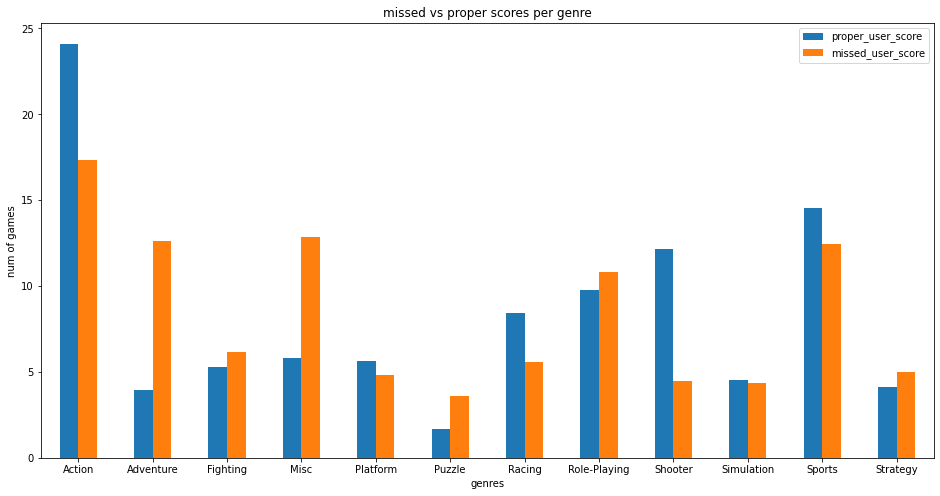

In [50]:
missed_user_score = games[games['user_score'].isna()]

valued_user_score = games.merge(missed_user_score, how='outer', indicator=True).query('_merge == "left_only"').drop('_merge', 1)
valued_user_score
valued_user_score = valued_user_score.groupby('genre')['platform'].count().to_frame().add_suffix('').reset_index().rename(columns={'platform':'valued_user_score'})
missed_user_score = missed_user_score.groupby('genre')['platform'].count().to_frame().add_suffix('').reset_index().rename(columns={'platform':'missed_user_score'})


merged_score2 = proper_user_score.merge(missed_user_score,how='inner',on='genre')

va = merged_score2.proper_user_score.sum()
mi = merged_score2.missed_user_score.sum() # its not all type of platforms so about 1408 rows are left out of both sums
merged_score2['proper_user_score'] = merged_score2['proper_user_score'] / va * 100
merged_score2['missed_user_score'] = merged_score2['missed_user_score'] / mi * 100

ax = merged_score2.plot.bar(x='genre', y=['proper_user_score','missed_user_score'], rot=0, figsize=(16,8))
plt.xlabel('genres')
plt.ylabel('num of games')
plt.title("missed vs proper scores per genre")
plt.show()

<div style="font-size:20px;">Thats a better match. Still, there are 6701 missing values, and we fill them based on 7590 proper values. Its not worth it. <p>given another year, I would try to fill per platform only if the match is good enough. and doing it with boxplots from the beginning - is it a lot faster?</p><p><b>User_score will keep its missing values</b></p></div>

### Possible reasons for values to be missing

<div style="font-size:20px;"><p>Critics, scores and ratings might be performed by official companies, such as michelin for restaurants - a prestigous game reviewer critic, a popular game site and a special board who determines game ratings. As to the professional critic and the rating board - they're only human so cant review all games. And for the games site - it too depends on users who bought the game and ready to spend some time for filling their review in the website.</p>
<p>Before internet was widely popular - before the mid 90's - user scores obviously had to be much sparser.</p>
<p>Those 2 missing values for name and genre might be a human error. When going through the data by year and platform those 2 values were deleted for 2 subsequent rows.</p>
<p>Years missing values ended up being filled, because they were distributed "evenly". That suggests some random process is responsible for them - for example, the data might have been assembled from a lot of different tables, containing different columns. In each iteration, missing year values were added to an extent, but not completely - its a lot of work.</p></div>


## Enriching games with 'total_sales' column

In [51]:
games['total_sales'] = games[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

# Analysis

## Game releases per year

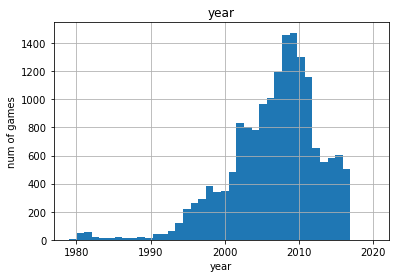

In [52]:
games.hist('year',bins=40, range=(1979,2020))
plt.title('year')
plt.ylabel('num of games')
plt.xlabel('year')
plt.show()

<div style="font-size:20px;">Before around 1994, the data is problematic. From one hand, there's relatively not a lot of data, and thats bad for analysis. On the other hand, if there's an intereset in data from the years before 1994, each row of data from that era is only more valueble, as it has a bigger relative effect on the analysis (for that era). Its an era where internet is only at its first days, and accordingly much less games were released - the computer related market has been only rising from back then</div>

## Sales per platform

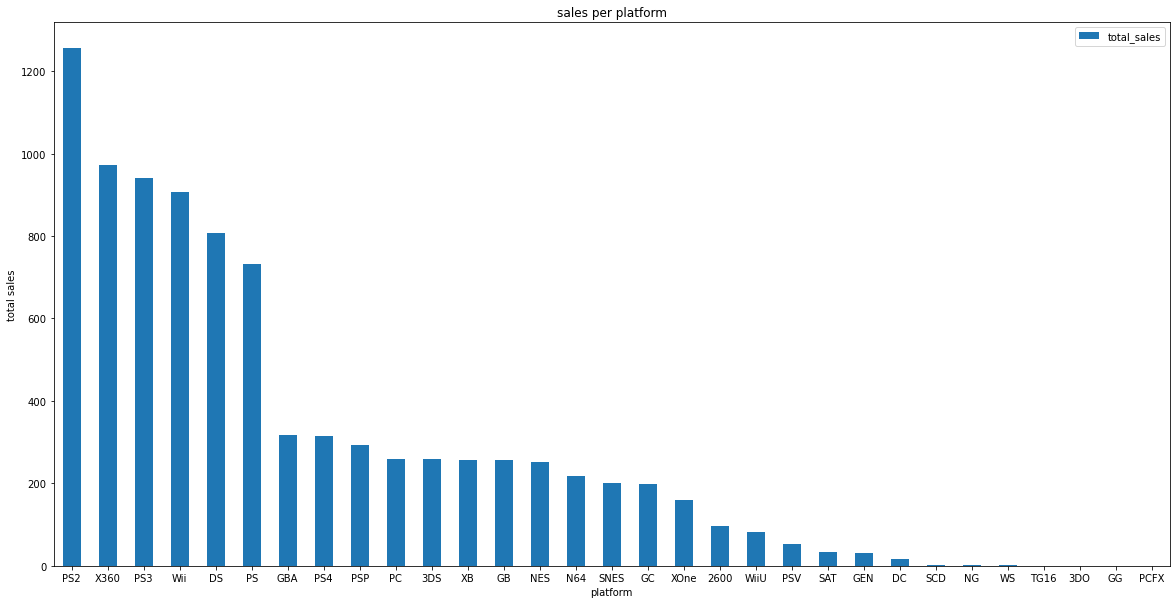

In [53]:
d = games.groupby('platform')['total_sales'].sum().to_frame().add_suffix('').reset_index()
d = d.sort_values('total_sales', ascending=False)

ax = d.plot.bar(x='platform', y='total_sales', rot=0,figsize=(20,10))
plt.title('sales per platform')
plt.ylabel('total sales')
plt.xlabel('platform')
plt.show()

<b style="font-size:20px;">PS2, X360, PS3, Wii, DS and PS are the most popular platforms</b>

## Sales per year for top platforms

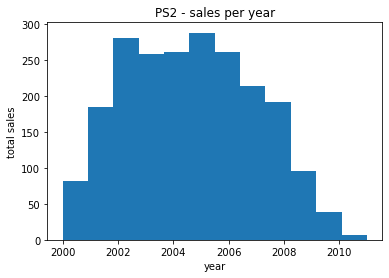

In [54]:
d = games[games['platform'] == 'PS2']
d.plot( x='total_sales', y='year', kind='hist', bins=12, legend=False)
plt.title('PS2 - sales per year')
plt.ylabel('total sales')
plt.xlabel('year')
plt.show()

<div style="font-size:20px;">PS2 used to be popular, but it doesn't now. It took 3 years to reach its peak popularity, and 5 years to fade to unconsciousness. The whole cycle took 11 years.</div>

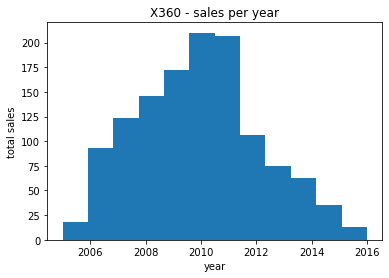

In [55]:
d = games[games['platform'] == 'X360']
d.plot( x='total_sales', y='year', kind='hist', bins=12, legend=False)
plt.title('X360 - sales per year')
plt.ylabel('total sales')
plt.xlabel('year')
plt.show()

<div style="font-size:20px;">X360 used to be popular, but it doesn't now. It took 5 years to reach its peak popularity, and 5 years to fade to unconsciousness. The whole cycle took 11 years.</div>

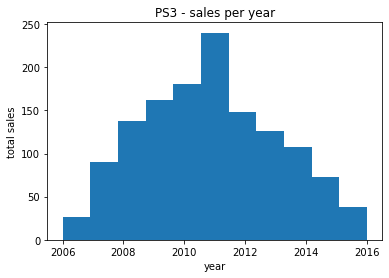

In [56]:
d = games[games['platform'] == 'PS3']
d.plot( x='total_sales', y='year', kind='hist', bins=11, legend=False)
plt.title('PS3 - sales per year')
plt.ylabel('total sales')
plt.xlabel('year')
plt.show()

<div style="font-size:20px;">PS3 used to be popular, but it doesn't now. It took 5 years to reach its peak popularity, and 5 years to fade to unconsciousness. The whole cycle took 10 years.</div>

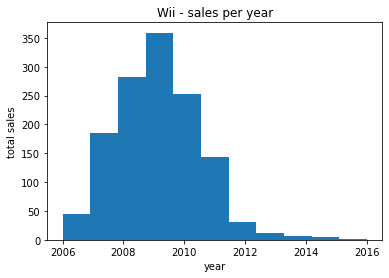

In [57]:
d = games[games['platform'] == 'Wii']
d.plot( x='total_sales', y='year', kind='hist', bins=11, legend=False)
plt.title('Wii - sales per year')
plt.ylabel('total sales')
plt.xlabel('year')
plt.show()

<div style="font-size:20px;">Wii used to be popular, but it doesn't now. It took 3 years to reach its peak popularity, and 4 years to fade to unconsciousness. The whole cycle took 7 years.</div>

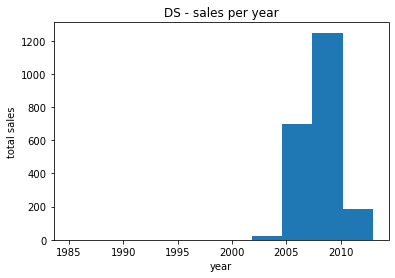

In [58]:
d = games[games['platform'] == 'DS']
d.plot( x='total_sales', y='year', kind='hist', bins=10, legend=False)
plt.title('DS - sales per year')
plt.ylabel('total sales')
plt.xlabel('year')
plt.show()

<div style="font-size:20px;">DS used to be popular, but it doesn't now. It took 5 years to reach its peak popularity, and 4 years to fade to unconsciousness. The whole cycle took 10 years.</div>

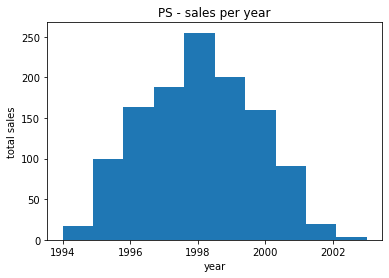

In [59]:
d = games[games['platform'] == 'PS']
d.plot( x='total_sales', y='year', kind='hist', bins=10, legend=False)
plt.title('PS - sales per year')
plt.ylabel('total sales')
plt.xlabel('year')
plt.show()

<div style="font-size:20px;">PS used to be popular, but it doesn't now. It took 4 years to reach its peak popularity, and 4 years to fade to unconsciousness. The whole cycle took 9 years.</div>

<div style="font-size:20px;">Turns out platforms take about 5 years to reach their peak, where they stay for around a year, before entering another 5 years of movement, this time down. Overall, platform lives for around 10 years.</div>

## ADDITIONAL PLATFORMS

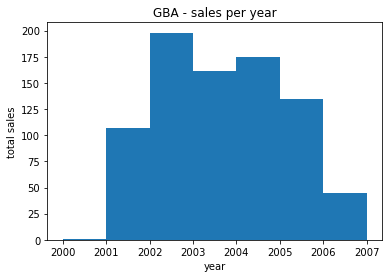

In [60]:
d = games[games['platform'] == 'GBA']
d.plot( x='total_sales', y='year', kind='hist', bins=7, legend=False)
plt.title('GBA - sales per year')
plt.ylabel('total sales')
plt.xlabel('year')
plt.show()

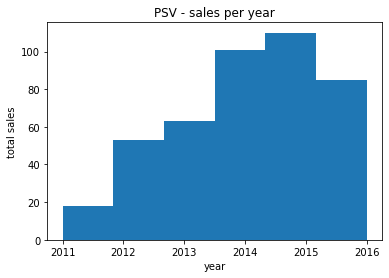

In [61]:
d = games[games['platform'] == 'PSV']
d.plot( x='total_sales', y='year', kind='hist', bins=6, legend=False)
plt.title('PSV - sales per year')
plt.ylabel('total sales')
plt.xlabel('year')
plt.show()

<h1 style="color:red;"><b>!!!!!!!!!PSV LOOKING GOOD FOR 2017!!!!!!!(|-`:)</b></h1>

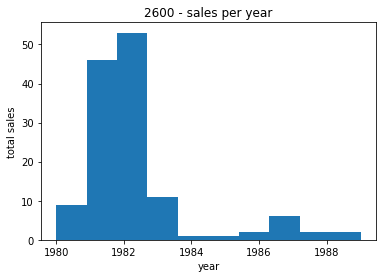

In [62]:
d = games[games['platform'] == '2600']
d.plot( x='total_sales', y='year', kind='hist', bins=10, legend=False)
plt.title('2600 - sales per year')
plt.ylabel('total sales')
plt.xlabel('year')
plt.show()

## 2017 PROGNOSIS

<div style="font-size:20px;">A prognosis needs to be done for 2017. Platforms from 2007 will be at the end of their lives at 2017. This prognosis is done in order to find winning horses - so no point looking at platforms that are only going down. Relevent platforms are the ones now at their peak, where they can stay for a while, or the ones that are in the middle of their rise. A platform can stay a year at its peak, and it takes 5 years for it to get there. together thats 6 years. So just the data from 2011 onwards will be great.</div>

In [63]:
games_filtered = games.query('year > 2011')
games_filtered

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,NaN,nan,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1,NaN,nan,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1,NaN,nan,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,-1,NaN,nan,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1,NaN,nan,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1,NaN,nan,0.01


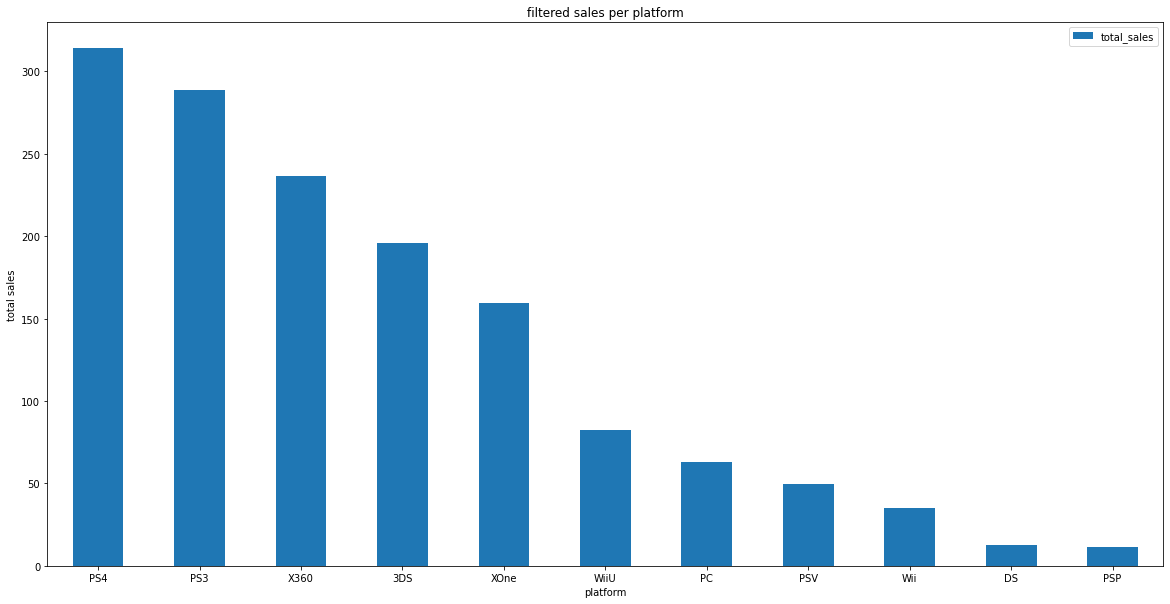

In [64]:
d = games_filtered.groupby('platform')['total_sales'].sum().to_frame().add_suffix('').reset_index()
d = d.sort_values('total_sales', ascending=False)
ax = d.plot.bar(x='platform', y='total_sales', rot=0,figsize=(20,10))
plt.title('filtered sales per platform')
plt.ylabel('total sales')
plt.xlabel('platform')
plt.show()

<div style="font-size:20px;">From the analysis above, regarding the most popular platforms, its clear PS3 and X360 are shrinking. PS4, 3DS and XOne look promising. WiiU and PC a bit less promising. Better to analyse them one by one:</div>

<div style="font-size:23px; color:red; font-weight:900;">Regarding PSV, its average is indeed around 50 based on his alarming histogram from before. But when i filter only years above 2013/14/15 PSV only getting smaller. So, im not sure whats going on here. Looks like PSV gonna have 50 million worth sales in 2017 (judging by the earlier histogram) so he's a big promise as well, for the next year or two.</div>

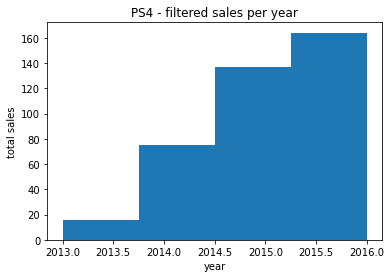

In [65]:
d = games_filtered[games_filtered['platform'] == 'PS4']
d.plot( x='total_sales', y='year', kind='hist', bins=4,legend=False)
plt.title('PS4 - filtered sales per year')
plt.ylabel('total sales')
plt.xlabel('year')
plt.show()

<div style="font-size:20px;">PS4 seem to be on the rise. Currently, PS4 games sell 160 million dollars a year. Should reach peak sells in 2018, and be a dominant player until 2021-22. the reflection of 2014 (first year to have good chunk of sales) in respect to 2018 (2013+5, according to the 10 year cycle rule) is 2022. But, the same reflection for end of 2014 and beginning of 2018 will be 2021, and hence the approximated range</div>

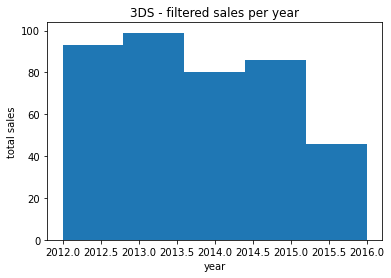

In [66]:
d = games_filtered[games_filtered['platform'] == '3DS']
d.plot( x='total_sales', y='year', kind='hist', bins=5,legend=False)
plt.title('3DS - filtered sales per year')
plt.ylabel('total sales')
plt.xlabel('year')
plt.show()

<div style="font-size:20px;">3DS seem to be going down. Currently, 3DS games sell 45 million dollars a year. Don't look promising</div>

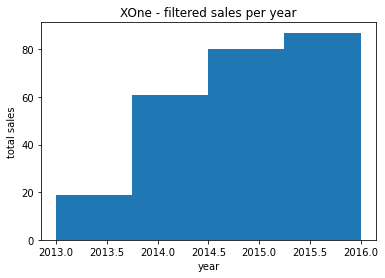

In [67]:
d = games_filtered[games_filtered['platform'] == 'XOne']
d.plot( x='total_sales', y='year', kind='hist', bins=4,legend=False)
plt.title('XOne - filtered sales per year')
plt.ylabel('total sales')
plt.xlabel('year')
plt.show()

<div style="font-size:20px;">XOne seem to be on the rise. Currently, XOne games sell 85 million dollars a year. This platform should be at its peak around 2018, and be a dominant player until 2021-2022. the reflection of 2014 (first year to have good chunk of sales) in respect to 2018 (2013+5, according to the 10 year cycle rule) is 2022. But, the same reflection for end of 2014 and beginning of 2018 will be 2021, and hence the approximated range</div>

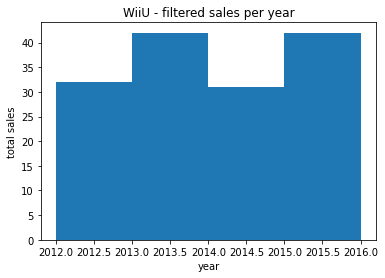

In [68]:
d = games_filtered[games_filtered['platform'] == 'WiiU']
d.plot( x='total_sales', y='year', kind='hist', bins=4, legend=False)
plt.title('WiiU - filtered sales per year')
plt.ylabel('total sales')
plt.xlabel('year')
plt.show()

<div style="font-size:20px;">WiiU seem to be on its peak. Currently, WiiU games sell 40 million dollars a year.</div>

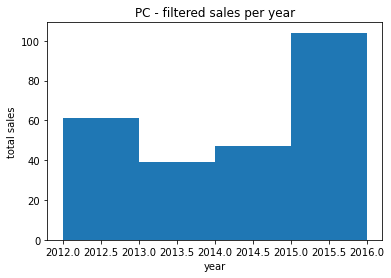

In [69]:
d = games_filtered[games_filtered['platform'] == 'PC']
d.plot( x='total_sales', y='year', kind='hist', bins=4, legend=False)
plt.title('PC - filtered sales per year')
plt.ylabel('total sales')
plt.xlabel('year')
plt.show()

<div style="font-size:20px;">PC seem to be on its peak. Currently, PC games sell 110 million dollars a year. Seems its also a winning horse for the next 2 to 3 years, with approximately 40 MUSD sales a year</div>
<div style="font-size:23px; color:red; font-weight:900;">Like the case with PSV, i don't understand howcome PC didn't came up when i filtered the data for various years between 2011 to 2017</div>

## Potentially profitable platforms

<div style="font-size:20px;">PS4, PC, and XOne have a lot of potential - they're the top sellers for 2016, and probably keep the high sells for few more years. PS4 and XOne will peak at 2018, so good sales will continue until possibly 2021. PC might start to fall soon, but still, it has a big portion of sells at present (bigger than XOne) and the sales look stable, so good chance the fall will take some time, while PC could keep the high sales.<p style="color:red; font-weight:900;">In addition, the PSV platform looks promising and forecasted to sale 70 MUSD in 2017 and 40 MUSD in 2018 before fading</p></div>

## Sales per platform Boxplot

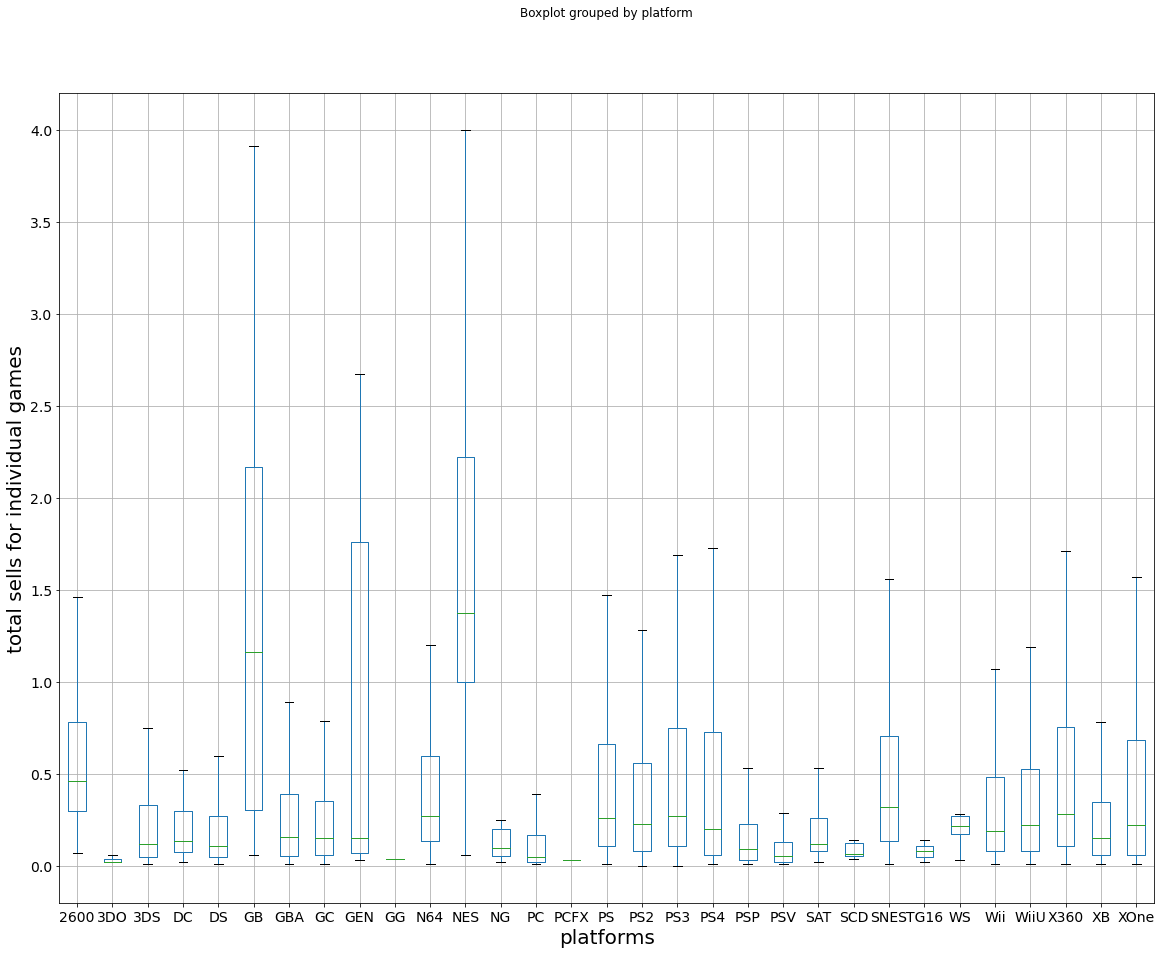

In [70]:
games.boxplot(column="total_sales", by="platform",fontsize = 14,figsize=(19,15),showfliers=False)
plt.title('')
plt.ylabel('total sells for individual games', fontsize=20)
plt.xlabel('platforms', fontsize=20)
plt.show()

<div style="font-size:20px;"><p>Some platforms, mainly DS, GB, NES and Wii - are particulary unique in that not a lot of games reach total sells of over 25 MUSD, and turns out those who do are played using those specific platforms - it must say something about those platforms - probably allowed user experience unique to the platform that those high selled games took advantage; For example, an introduction of a flight joystick platform and a flight simulator game, at a time when there's no other counterpart for either the platform or the game</p>
<p>Other platforms - SCD, NG, WS, TG16, 3DO, GG and PCFX are unique in that no game played using them had any substantial sells, if any. Those platforms probably didn't used by a lot of games, as there are not a lot of black dots in their boxes. Either those platforms were terribly engineered, or they were active when the market for games was low (before 1995)</p>
<p></p>
<p>However, the average sales are all the same, almost - the platforms containing the extremely profitable games are usually (from previous analysis and common sense) the more popular platforms, hence they're average involves hundreds or thousands of games</p></div>

## Score and critics effect on sales - for popular platforms

### Categorising user_score and critic_score

In [71]:
def catc(crit):
        if crit == 100:
            return 10
        elif crit < 100 and crit >= 90:
            return 9
        elif crit < 90 and crit >= 80:
            return 8
        elif crit < 80 and crit >= 70:
            return 7
        elif crit < 70 and crit >= 60:
            return 6
        elif crit < 60 and crit >= 50:
            return 5
        elif crit < 50 and crit >= 40:
            return 4
        elif crit < 40 and crit >= 30:
            return 3
        elif crit < 30 and crit >= 20:
            return 2
        elif crit < 20 and crit >= 10:
            return 1
        elif crit < 10 and crit >= 0:
            return 0
        
def catu(score):
        if score == 10:
            return 10
        elif score < 10 and score >= 9:
            return 9
        elif score < 9 and score >= 8:
            return 8
        elif score < 8 and score >= 7:
            return 7
        elif score < 7 and score >= 6:
            return 6
        elif score < 6 and score >= 5:
            return 5
        elif score < 5 and score >= 4:
            return 4
        elif score < 4 and score >= 3:
            return 3
        elif score < 3 and score >= 2:
            return 2
        elif score < 2 and score >= 1:
            return 1
        elif score < 1 and score >= 0:
            return 0
        elif score == -1:
            return -1
        
games['critic_score_cat'] = games['critic_score'].apply(catc)    
games['user_score_cat'] = games['user_score'].apply(catu)

### Choosing a good data-wise platform 

In [72]:
proper_user_score = games[games['user_score'] != -1].dropna(subset=['user_score'])

# removing all nans that were unfortunately replaced by -1 before
proper_critic_score = games[games['critic_score'] != -1]

grouped_score = proper_user_score.groupby('platform')['user_score'].count().to_frame().add_suffix('').reset_index()
grouped_critic = proper_critic_score.groupby('platform')['critic_score'].count().to_frame().add_suffix('').reset_index()

# get cake share of games by platform
plat = games.platform.value_counts().to_frame().add_suffix('').reset_index().rename(columns={'index':'platform', 'platform':'num'})

# arranging data for platform and critics
dwi = grouped_critic.merge(plat,how='inner',on='platform')
dwi['critic_score'] = dwi['critic_score'] / dwi['num']
dwi = dwi.drop('num',1)

# again for user scores
dw = grouped_score.merge(plat,how='inner',on='platform')
dw['user_score'] = dw['user_score'] / dw['num']
dw = dw.drop('num',1)

dwip = dwi.merge(dw,how='inner',on='platform')
dwip['s'] = dwip['critic_score'] + dwip['user_score']
dwip = dwip.sort_values('s',ascending=False).drop('s',1)
dwip
# got a table based solely on proper review values to aid in choosing the platform for the question

,platform,critic_score,user_score
15,XB,0.879854,0.711165
5,PC,0.734086,0.790554
14,X360,0.725832,0.765452
4,GC,0.805755,0.658273
16,XOne,0.684211,0.736842
9,PS4,0.642857,0.655612
13,WiiU,0.612245,0.680272
8,PS3,0.616078,0.658903
7,PS2,0.600648,0.574271
12,Wii,0.443182,0.424242


<div style="font-size:20px;"><p>X360 has a relatively good data, as its 3rd place in the latter table, with no serious differences between it and the 1st place. In addition, X360 is the 2nd most popular platform ever (using the plot earlier for all time platform popularity).</p>
<p>So, the X360 will be chosen for the task</p></div>

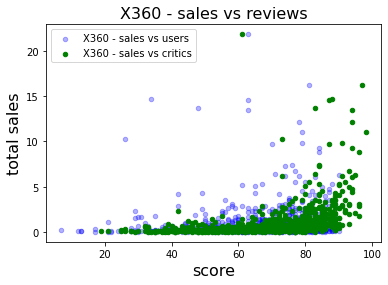

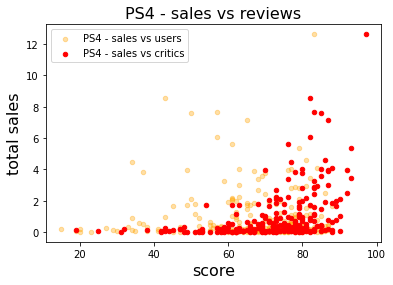

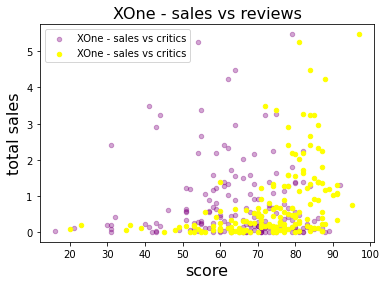

In [73]:
games['user_score100'] = games['user_score'] * 10 # so both reviews will stretch from 0 to 100
games['critic_score100'] = games['critic_score']

#without that, there's 2 vertical lines around -1 and -10
games.loc[games['user_score100'] == -10,'user_score100'] = np.nan
games.loc[games['critic_score100'] == -1,'critic_score100'] = np.nan

X360_games = games[games['platform'] == 'X360']
PS4_games = games[games['platform'] == 'PS4']
XOne_games = games[games['platform'] == 'XOne']


ax = X360_games.plot(kind="scatter", x="user_score100",y="total_sales", color="b", label="X360 - sales vs users",alpha=0.3)
X360_games.plot(kind="scatter",x="critic_score100",y="total_sales", color="g", label="X360 - sales vs critics", ax=ax)

ax.set_title("X360 - sales vs reviews",fontsize=16)
ax.set_xlabel("score",fontsize=16)
ax.set_ylabel("total sales", fontsize=16)
plt.show()

# PS4
ax = PS4_games.plot(kind="scatter", x="user_score100",y="total_sales", color="orange", label="PS4 - sales vs users", alpha=0.35)
PS4_games.plot(kind="scatter", x="critic_score100",y="total_sales", color="r", label="PS4 - sales vs critics", ax=ax)

ax.set_title("PS4 - sales vs reviews",fontsize=16)
ax.set_xlabel("score",fontsize=16)
ax.set_ylabel("total sales", fontsize=16)
plt.show()

# XOne
ax = XOne_games.plot(kind="scatter",x="user_score100",y="total_sales", color="purple", label="XOne - sales vs critics", alpha=0.35)
XOne_games.plot(kind="scatter", x="critic_score100",y="total_sales", color="yellow", label="XOne - sales vs critics", ax=ax)

ax.set_title("XOne - sales vs reviews",fontsize=16)
ax.set_xlabel("score",fontsize=16)
ax.set_ylabel("total sales", fontsize=16)
plt.show()

<div style="font-size:20px;"><p>All plots illustrate that generally, better reviews achieve better sales - they all have a slight curve up to the right, spanning all across scores (i.e from 0 to 100). in Addition, the scores seems to hit a wall around 85-90 score. That might be becuase people rarely rate something as 10. Mostly, 9 is considered an upper bound for this type of scores.</p><p>However, besides the slight curve up to the right, the data doesn't look too correlated</p></div>

In [74]:
print('X360 scores correlation -',X360_games['user_score100'].corr(X360_games['total_sales']))
print('X360 critic correlation -',X360_games['critic_score100'].corr(X360_games['total_sales']))
print('PS4 scores correlation -',PS4_games['user_score100'].corr(PS4_games['total_sales']))
print('PS4 critic correlation -',PS4_games['critic_score100'].corr(PS4_games['total_sales']))
print('XOne scores correlation -',XOne_games['user_score100'].corr(XOne_games['total_sales']))
print('XOne critic correlation -',XOne_games['critic_score100'].corr(XOne_games['total_sales']))

X360 scores correlation - 0.11445882978454186
X360 critic correlation - 0.39373586530725874
PS4 scores correlation - -0.031957110204556445
PS4 critic correlation - 0.40656790206178095
XOne scores correlation - -0.06892505328279411
XOne critic correlation - 0.4169983280084017


<div style="font-size:20px;">Indeed, the correlation is medium and below.</div>

## Sales by Genre

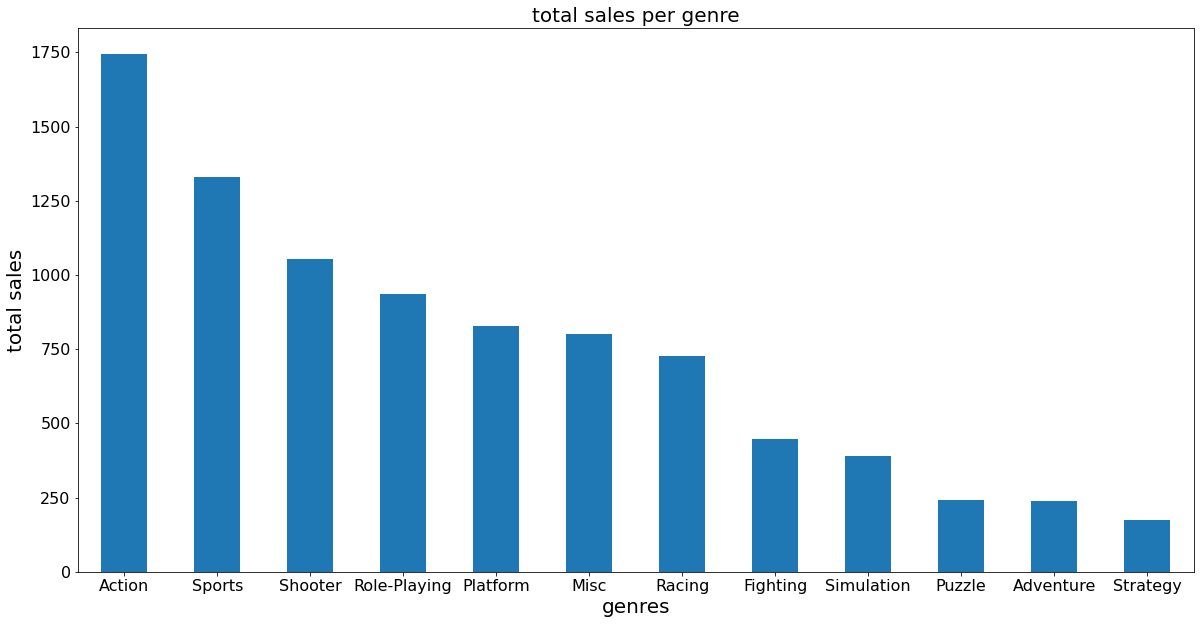

In [75]:
sales_per_genre = games.groupby('genre')['total_sales'].sum().sort_values().to_frame().add_suffix('').reset_index().sort_values('total_sales', ascending=False)
sales_per_genre.plot.bar(x='genre', y='total_sales', rot=0,figsize=(20,10), fontsize=16, legend=False)
plt.title('total sales per genre', fontsize=20)
plt.ylabel('total sales', fontsize=20)
plt.xlabel('genres', fontsize=20)
plt.show()

<div style="font-size:20px;"><p>Action, Sports and Shooter are the most profitable genres. Essentially, they're all action games.</p>
<p>Games involve action and thrills, that require the player to respond fast and develop specific technical expertise are more popular.</p> <p>Games involve analysis, that require the player to develop patience and inner-peace are less popular (Simulation, Puzzle, Strategy)</p></div> 

# User profile

## Platform Profile

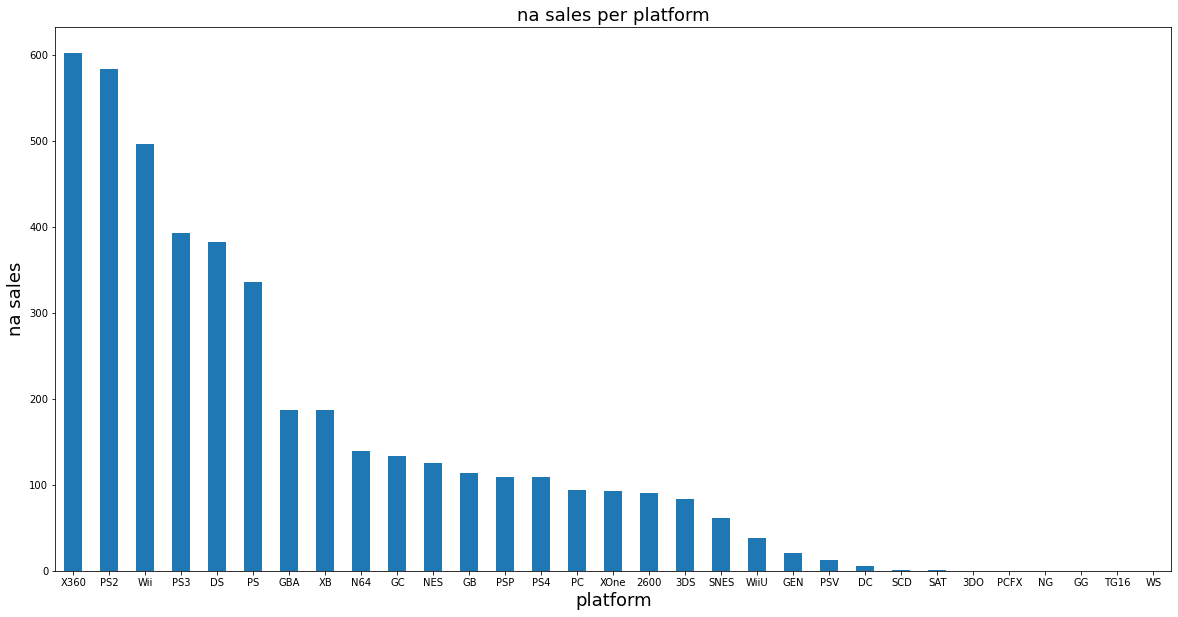

In [76]:
d = games.groupby('platform')['na_sales'].sum().to_frame().add_suffix('').reset_index()
d = d.sort_values('na_sales', ascending=False)
ax = d.plot.bar(x='platform', y='na_sales', rot=0,figsize=(20,10),legend=False)
plt.title('na sales per platform', fontsize=18)
plt.ylabel('na sales',fontsize=18)
plt.xlabel('platform',fontsize=18)
plt.show()

<div style="font-size:20px;">Top 5 all-time North-America platforms are X360, PS2, Wii, PS3 and DS</div>

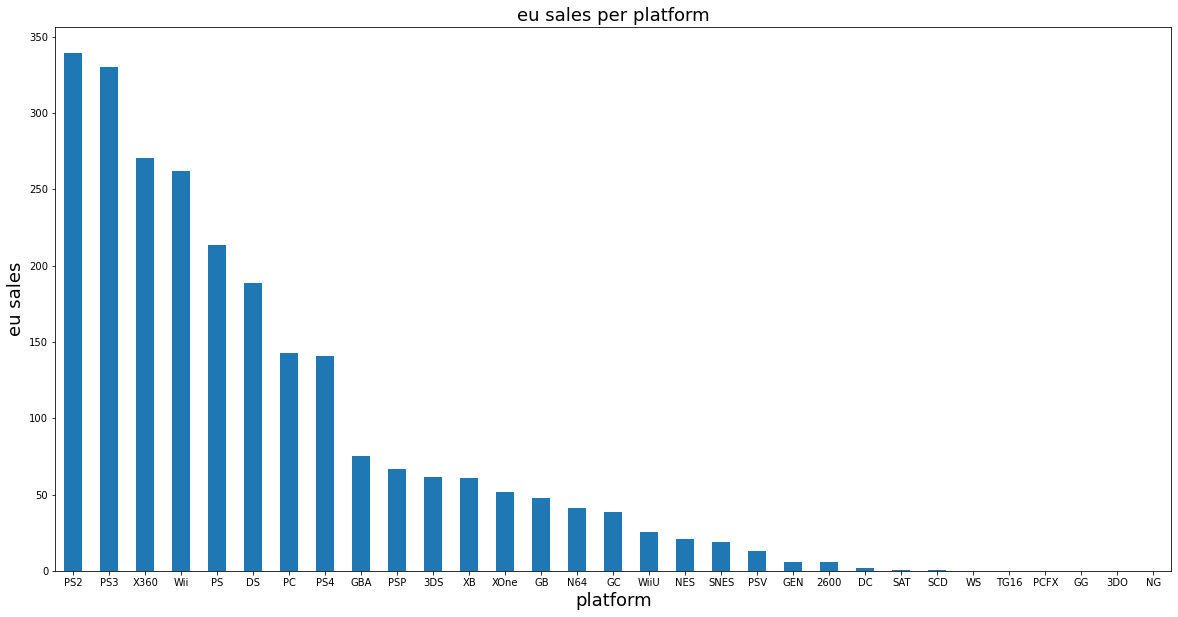

In [77]:
d = games.groupby('platform')['eu_sales'].sum().to_frame().add_suffix('').reset_index()
d = d.sort_values('eu_sales', ascending=False)
ax = d.plot.bar(x='platform', y='eu_sales', rot=0,figsize=(20,10),legend=False)
plt.title('eu sales per platform', fontsize=18)
plt.ylabel('eu sales', fontsize=18)
plt.xlabel('platform', fontsize=18)
plt.show()

<div style="font-size:20px;">Top 5 all-time European platforms are PS2, PS3, X360, Wii and PS</div>

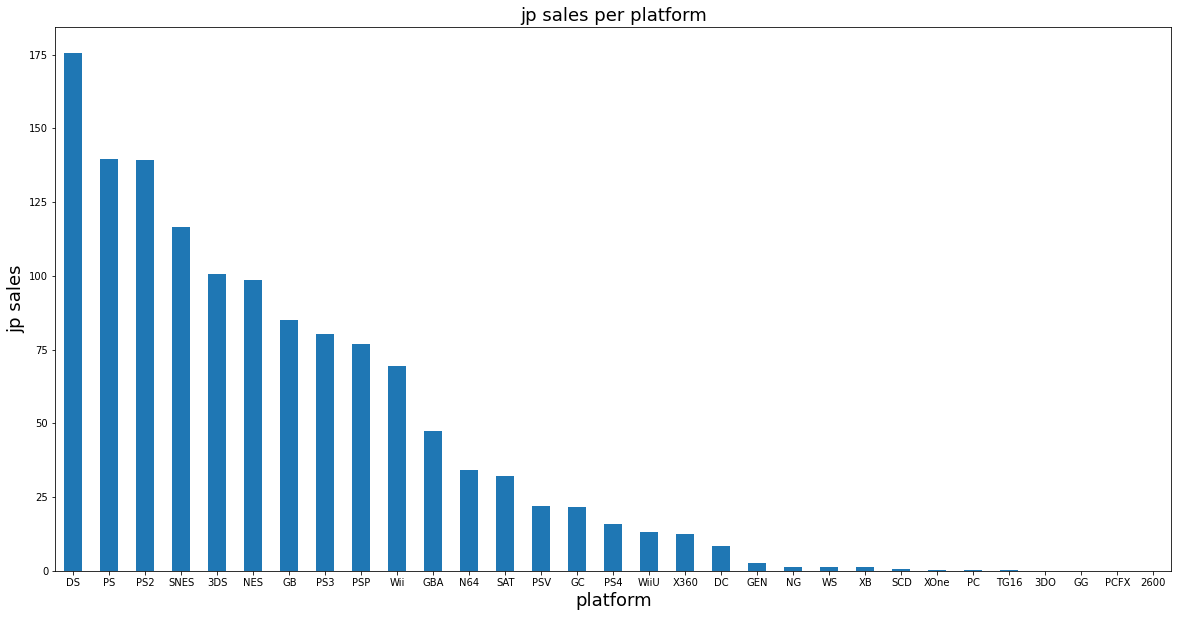

In [78]:
d = games.groupby('platform')['jp_sales'].sum().to_frame().add_suffix('').reset_index()
d = d.sort_values('jp_sales', ascending=False)
ax = d.plot.bar(x='platform', y='jp_sales', rot=0,figsize=(20,10),legend=False)
plt.title('jp sales per platform', fontsize=18)
plt.ylabel('jp sales', fontsize=18)
plt.xlabel('platform', fontsize=18)
plt.show()

<div style="font-size:20px;">Top 5 all-time Japanese platforms are DS, PS, PS2, SNES and 3DS</div>

### Platform profile summation

<div style="font-size:20px;">American and European platform shares are related - they share the top 4 platforms, and top 5-6 platforms. The Japanese market is different - its top 2 are the latters top 5-6. At 3rd place stands PS2, which is very succesful in America and Europe. 4th and 5th top Japanese platforms are not so popular in both America and Europe</div>

## Genre Profile

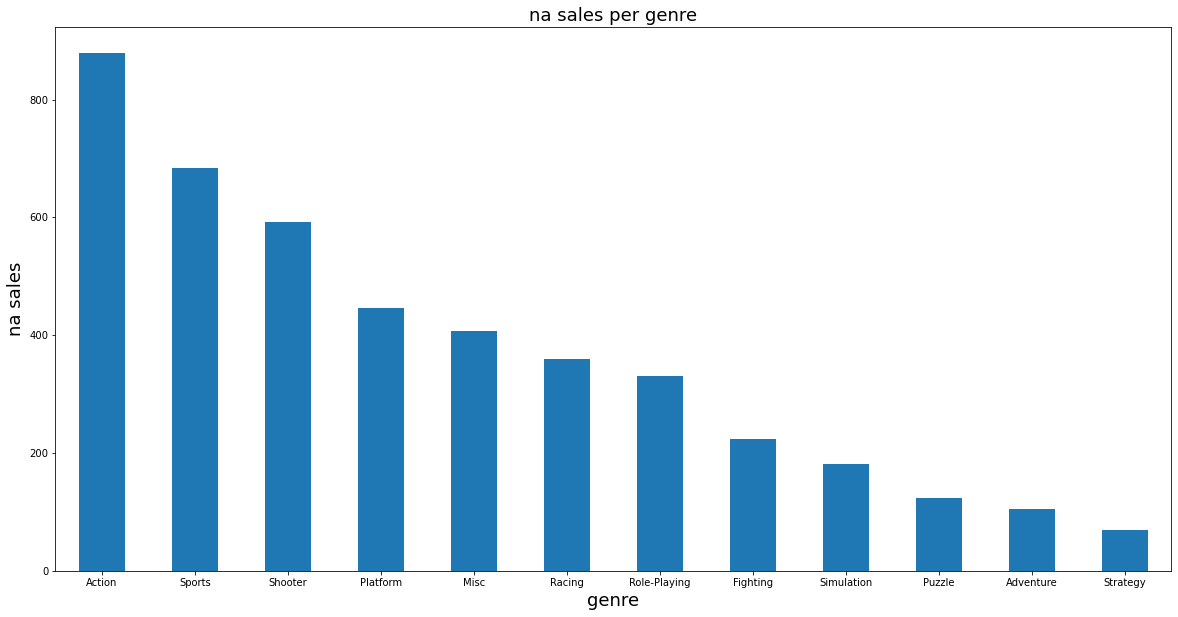

In [79]:
d = games.groupby('genre')['na_sales'].sum().to_frame().add_suffix('').reset_index()
d = d.sort_values('na_sales', ascending=False)
ax = d.plot.bar(x='genre', y='na_sales', rot=0,figsize=(20,10), legend=False)
plt.title('na sales per genre',fontsize=18)
plt.ylabel('na sales',fontsize=18)
plt.xlabel('genre',fontsize=18)
plt.show()

<div style="font-size:20px;">Top genres for North America are Action, Sports, Shooter, Platform and Misc</div>

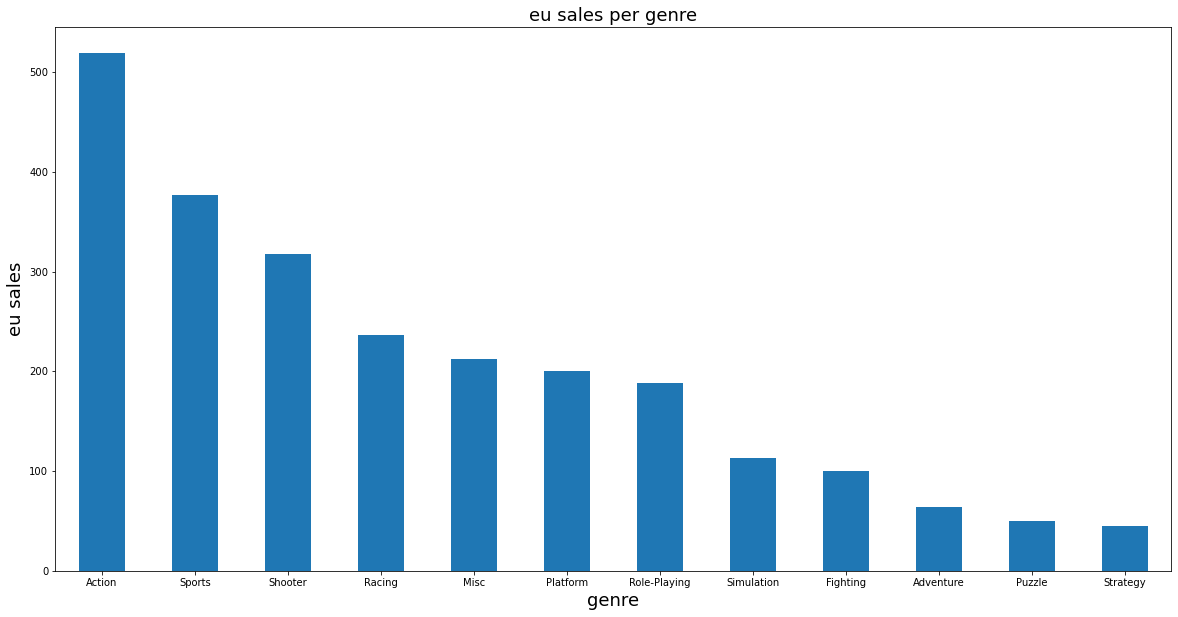

In [80]:
d = games.groupby('genre')['eu_sales'].sum().to_frame().add_suffix('').reset_index()
d = d.sort_values('eu_sales', ascending=False)
ax = d.plot.bar(x='genre', y='eu_sales', rot=0,figsize=(20,10), legend=False)
plt.title('eu sales per genre',fontsize=18)
plt.ylabel('eu sales',fontsize=18)
plt.xlabel('genre',fontsize=18)
plt.show()

<div style="font-size:20px;">Top genres for Europe are Action, Sports, Shooter, Racing and Misc</div>

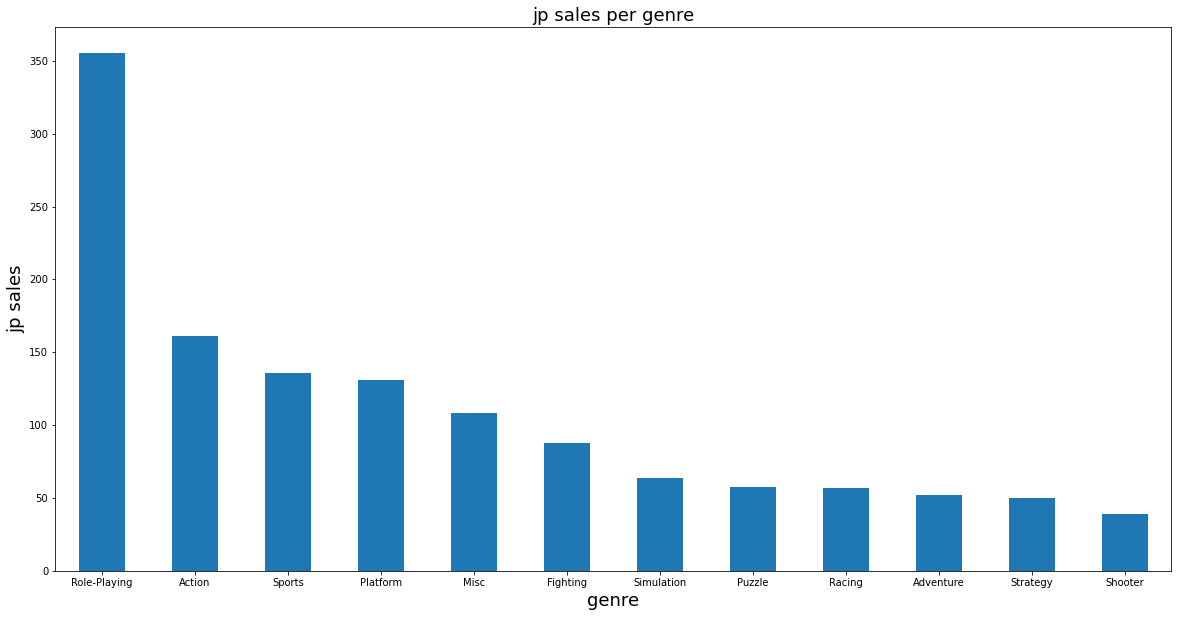

In [81]:
d = games.groupby('genre')['jp_sales'].sum().to_frame().add_suffix('').reset_index()
d = d.sort_values('jp_sales', ascending=False)
ax = d.plot.bar(x='genre', y='jp_sales', rot=0,figsize=(20,10),legend=False)
plt.title('jp sales per genre',fontsize=18)
plt.ylabel('jp sales',fontsize=18)
plt.xlabel('genre',fontsize=18)
plt.show()

<div style="font-size:20px;">Top genres for Japan are Role-Playing, Action, Sports, Platform and Misc</div>

### Genre profile summation

<div style="font-size:20px;"><p>European and American markets are almost the same - they have the same top genres, in the same order, only that the one's 4th place genre is the other's 6th place genre.</p>
<p>Japanese market feature the same top genres as NA and Europe - at 2nd to 5th places. Japanese most popular genre, by far, is Role-Playing, a genre with medium popularity in NA and Europe. This difference might be explained by japanese love of everything connected to anime and such; probably its Role-Playing with characters from famous anime TV shows</p></div>

## Rating Profile

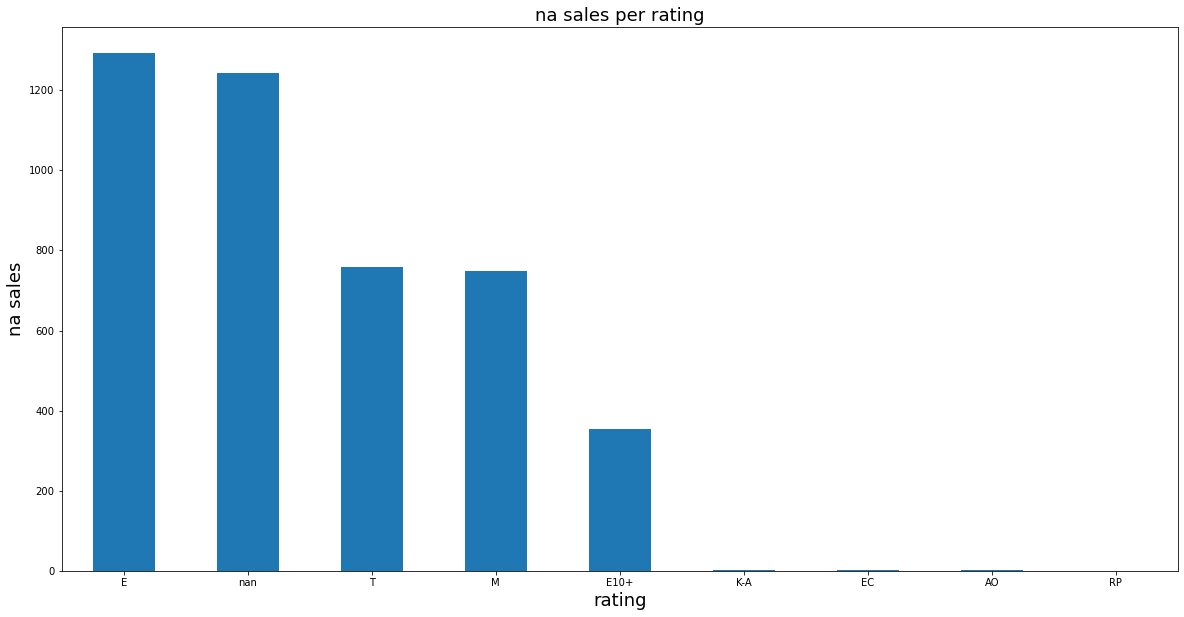

In [82]:
d = games.groupby('rating')['na_sales'].sum().to_frame().add_suffix('').reset_index()
d = d.sort_values('na_sales', ascending=False)
ax = d.plot.bar(x='rating', y='na_sales', rot=0,figsize=(20,10),legend=False)
plt.title('na sales per rating',fontsize=18)
plt.ylabel('na sales',fontsize=18)
plt.xlabel('rating',fontsize=18)
plt.show()

<div style="font-size:20px;">Top ratings are E, T and M. Unknowns are almost popular as E rating.</div>

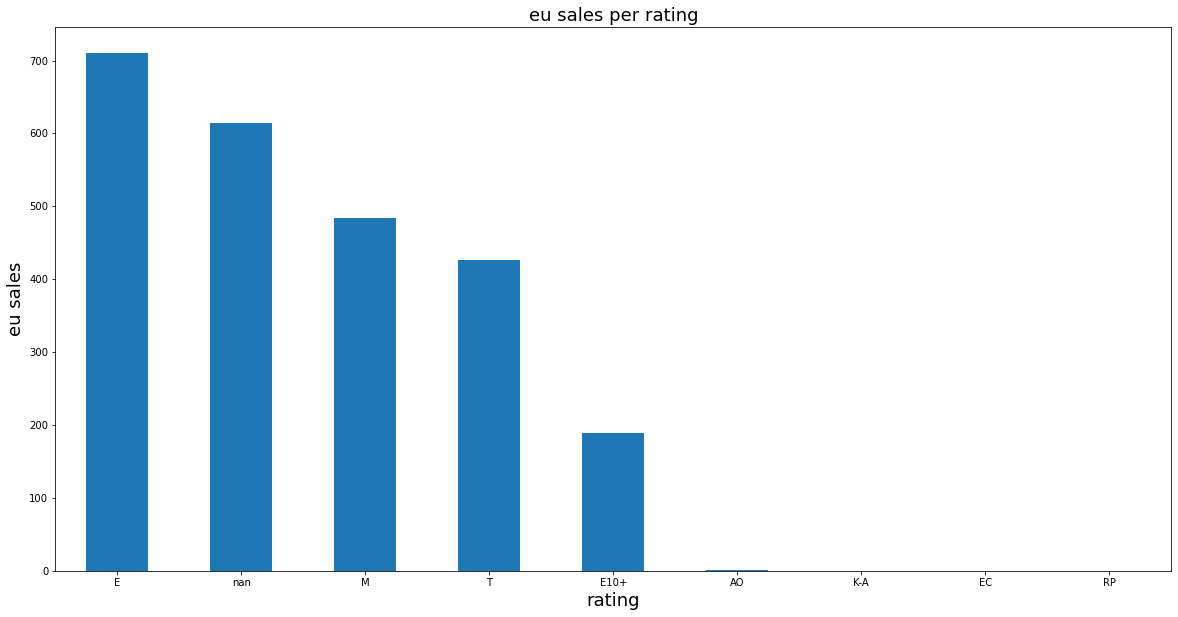

In [83]:
d = games.groupby('rating')['eu_sales'].sum().to_frame().add_suffix('').reset_index()
d = d.sort_values('eu_sales', ascending=False)
ax = d.plot.bar(x='rating', y='eu_sales', rot=0,figsize=(20,10),legend=False)
plt.title('eu sales per rating',fontsize=18)
plt.ylabel('eu sales',fontsize=18)
plt.xlabel('rating',fontsize=18)
plt.show()

<div style="font-size:20px;">Top ratings are E, M and T. Again, unknowns are almost as popular as the most popular rating</div>

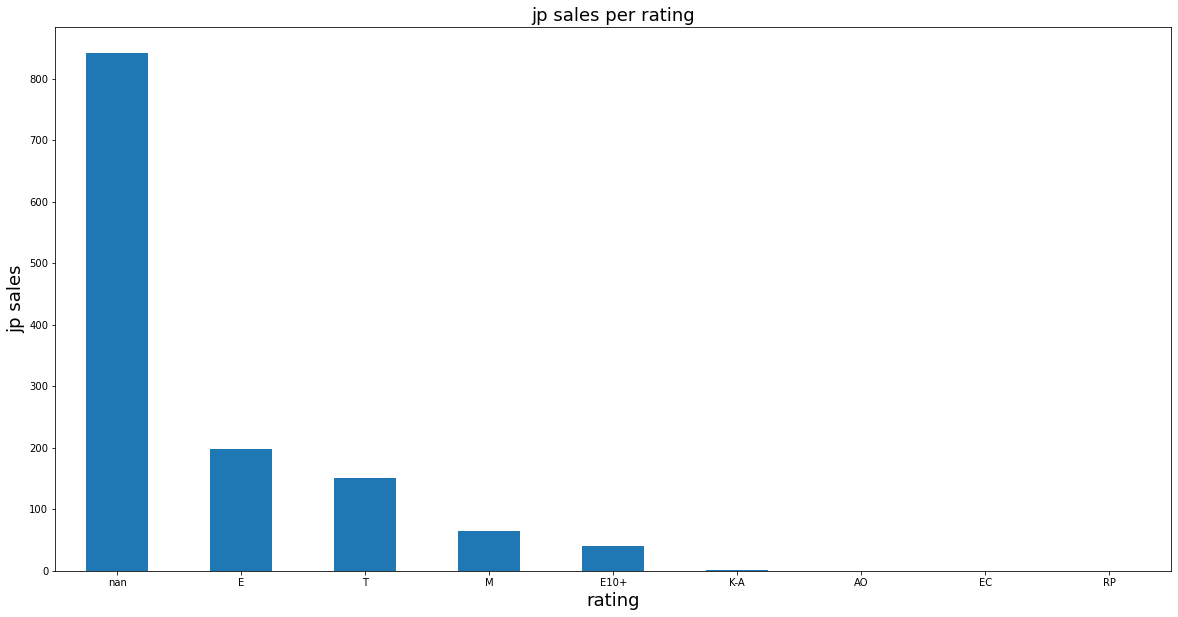

In [84]:
d = games.groupby('rating')['jp_sales'].sum().to_frame().add_suffix('').reset_index()
d = d.sort_values('jp_sales', ascending=False)
ax = d.plot.bar(x='rating', y='jp_sales', rot=0,figsize=(20,10),legend=False)
plt.title('jp sales per rating',fontsize=18)
plt.ylabel('jp sales',fontsize=18)
plt.xlabel('rating',fontsize=18)
plt.show()

<div style="font-size:20px;">Top ratings are E, T and M. But here, unknowns are 4 times more popular than the following most popular rating</div>

### Rating Profile summation

<div style="font-size:20px;">E, T and M are the popular ratings. E is without a doubt the most popular rating in all areas. Japan has tons of missed ratings - maybe all those Role-Playing Japan made games are not regulated by the rating committee
</div>

# Hypotheses

In [85]:
proper_users = games[games['user_score'] != -1].dropna(subset=['user_score'])

chart_xone = proper_users[proper_users['platform'] == 'XOne']
chart_pc = proper_users[proper_users['platform'] == 'PC']
chart_action = proper_users[proper_users['genre'] == 'Action']
chart_sport = proper_users[proper_users['genre'] == 'Sports']

score_xone = chart_xone['user_score']
score_pc= chart_pc['user_score']
score_action = chart_action['user_score']
score_sport = chart_sport['user_score']
print(f'variation for both platforms - {score_xone.var()},{score_pc.var()}. ratio - {score_xone.var()/score_pc.var()}')
print(f'variation for both genres - {score_action.var()},{score_sport.var()}. ratio - {score_action.var()/score_sport.var()}')

variation for both platforms - 1.9069968429360702,2.3407871413372. ratio - 0.8146818688719717
variation for both genres - 2.031746898033191,2.5965147189730073. ratio - 0.7824900368124247


<div style="font-size:20px; font-weight:900;"><p>Variation for platforms will be considered equal</p>
<p>Variation for genres will be considered unequal</p>
</div>

<div class="font-size:25px;">
<b>
H0: the user ratings means for Xbox One and PC platforms are equal
    
H1: the user ratings means for Xbox One and PC platforms differ</b></div>

In [86]:
alpha = 0.05 #normal alpha for a regular uncompromising hypotheses check

results = st.ttest_ind(score_xone, score_pc, equal_var=True)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 1.3896435533548819e-05
We reject the null hypothesis


<div class="font-size:25px;">
<b>
H0: the user ratings means for action and sport genres are equal
    
H1: the user ratings means for action and sport genres differ</b></div>

In [87]:
alpha = 0.05 #normal alpha for a regular uncompromising hypotheses check

results = st.ttest_ind(score_action, score_sport, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 0.11483818791498286
We can't reject the null hypothesis


# Conclusion

<div style="font-size:20px;"><p>The analysis purpose was to identify patterns that determine whether a game succeeds or not. So, some things turned out:</p>
<p>Before around 1995 games were much less released</p>
<p>Platforms have a lifecycle of around 10 years. For most, they rise linearly to popularity, and linearly fall down symmetrically, where rise and fall take about 5 years.</p>
<p>Reviews by users and critics don't reflect the success of a game</p>
<p>Most profitable genre is Action. Genres similar to Action are also pretty popular.</p>
<p>Analytic genres such as Strategy, Simulation and Puzzle are the least profitable</p>
<p>American and European platform shares are related - they share the top 4 platforms, and top 5-6 platforms. The Japanese market is different - its top 2 are the latters top 5-6. At 3rd place stands PS2, which is very succesful in America and Europe. 4th and 5th top Japanese platforms are not so popular in both America and Europe. So PS2 platform is the best ever worldwide platform. NA and europe share PS3, X360 and Wii as top platforms together with the worldwide best ever - PS2</p>
<p>In Japan, Role-Playing is the most profitable genre by far. Action games are 2nd place there</p>
<p>E, T and M are the popular ratings. E is without a doubt the most popular rating in all areas. Japan has tons of missed ratings - maybe all those Role-Playing Japan made games are not regulated by the rating committee
</p>
<p><b> 2017 Prognosis regarding top popular (i.e top total_sells) Platforms: </b></p>
<p>PS4 - Peak at 2018. good sales until 2021. currently sell 160 MUSD a year. Expected to sell 180 MUSD in the next 2 years. <b>The best investment</b></p>
<p>XOne - Peak at 2018. good sales until 2021. Currently sell 85 MUSD a year. Expected to sell 130 MUSD in the next 2 years.</p>
<p>PC - At its peak. good sales for the next 2 years. Currently sell 100 MUSD a year. Expected to sell 80 MUSD in the next 2 years.</p>
<p>PSV - peaked at 2015. good sales for the next 2 years. Currently sell 80 MUSD a year. Expected to sell 80 MUSD in the next 2 years.</p>
<p></p>
</div>